# CSC321 Tutorial 4: Multi-Class Classification with PyTorch

In this tutorial, we'll go through an example of a multi-class
linear classification problem using PyTorch.

Training models in PyTorch requires much less of the kind of code that you
are required to write for project 1.
However, PyTorch hides a lot of details of the computation,
both of the computation of the prediction, and the computation of the gradients. In your later
projects, you'll work with both numpy to understand deeply how your models actually work, but
also learn PyTorch to gain practical skills in building machine learning models.

In the process, we will:

- Introduce the MNIST dataset, which contains 28x28 pixel images of hand-written digits
- Introduce how to use of PyTorch to build and train models
- (If we have time) explore the effect of certain settings on our model:
    - Data set size
    - Batch size
    - Regularization

In [1]:
%matplotlib inline

## Data

The MNIST dataset contains black and white, hand-written (numerical) digits
that are 28x28 pixels large. This is a data set that is typically used for
demonstrations of machine learning models, and as a first data set to test
new types of models.

We will download the dataset. For simplicity, we'll only use the first 2500
images in the MNIST dataset. The first time you run this code, we will download
the MNIST dataset.

In [2]:
from torchvision import datasets

# load the training data
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_train = list(mnist_train)[:2500]

print(mnist_train[0]) 
# each feature is a pixel, 28x28 picture, 28 pixels

9920512it [00:02, 4058818.47it/s]                                                                                      


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 390093.62it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:00, 2721697.91it/s]                                                                                      


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 170667.17it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!
(<PIL.Image.Image image mode=L size=28x28 at 0x2A7C7C56A20>, 5)


Let's take a look at some of the data:

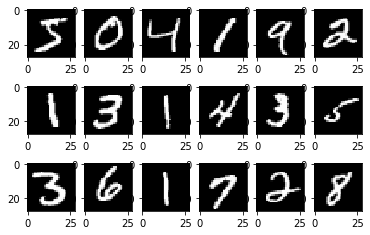

In [3]:
# plot the first 18 images in the training data
import matplotlib.pyplot as plt
for k, (image, label) in enumerate(mnist_train[:18]):
    plt.subplot(3, 6, k+1)
    plt.imshow(image, cmap='gray')

PyTorch has code written for us to convert an image into numerical pixel features.
The tensor still preserves the 2D geometry of the image (we still get a `1x28x28` shape) 
and does not yet flatten the image into a vector (to get a `1x784` shape) like we discussed
in lecture.

In [4]:
from torchvision import transforms
# transform the image data type to a 28x28 matrix of numbers
img_to_tensor = transforms.ToTensor()

# convert the last image we saw into a tensor
img_tensor = img_to_tensor(image)
img_tensor.shape
# 1 image is 28 by 28 

torch.Size([1, 28, 28])

If we want to convert the entire dataset into these tensor representations (as opposed to
PIL.Image objects), there is a `transform` parameter that we can use when loading the MNIST
dataset:

In [5]:
mnist_train = datasets.MNIST('data', train=True, transform=img_to_tensor)
mnist_train = list(mnist_train)[:2500]
print(mnist_train[0])
# zero is a black pixel

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Now, we'll split this data into training and validation, and start to build our model.
We won't need a test set for this tutorial, but in general we will also have a test set.

In [6]:
mnist_train, mnist_val = mnist_train[:2000], mnist_train[2000:]
# training and validation set, no test

## Linear Model in PyTorch

To build a linear model in PyTorch, we create an instance of the class `nn.Linear`,
and specify the number of input features, and the number of output features. For linear regression
and binary classification, the number of output features is 1. For multi-class classification,
we have as many outputs as there are classes.

When using this model for classification, we'll need to apply the sigmoid or softmax
activiation *afterwards*. That is, this object is only meant to handle the linear part of the
model computation.

In [7]:
import torch
import torch.nn as nn

example_model = nn.Linear(50, 1) # assume 50 features, 1 linear output

The `example_model` object contains weights and biases of the model. By default, PyTorch
initializes these values to a random number close to 0:

In [8]:
weight, bias = list(example_model.parameters())
print(weight)
print(weight.shape) #1x50
print(bias)
print(bias.shape)

Parameter containing:
tensor([[-0.0159,  0.1022, -0.0904, -0.0167, -0.0846,  0.0707, -0.1180,  0.1231,
          0.0554, -0.0211,  0.0189, -0.0602,  0.0674,  0.0208, -0.1329,  0.0159,
          0.0364, -0.0672, -0.1177,  0.0109,  0.0898, -0.0463, -0.0656,  0.1017,
          0.0480, -0.0427,  0.0893, -0.0750, -0.0522,  0.0577,  0.1201,  0.0806,
         -0.0233,  0.0826, -0.0569,  0.0329, -0.0441,  0.1331,  0.0573,  0.1023,
          0.0685, -0.1245,  0.0914, -0.0978,  0.0446, -0.1020,  0.0549,  0.1326,
          0.0980,  0.0510]], requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([-0.1083], requires_grad=True)
torch.Size([1])


If we create a new model, those initial parameters will change:

In [9]:
example_model = nn.Linear(50, 1)
weight, bias = list(example_model.parameters())

# These values should be different from above
print(weight)
print(weight.shape)
print(bias)
print(bias.shape)

Parameter containing:
tensor([[-1.3046e-01,  1.0784e-01,  9.8913e-02,  5.7477e-03, -2.5936e-02,
          1.9277e-02, -7.3569e-02, -6.4716e-02, -1.1062e-02, -1.1407e-01,
         -1.1106e-01, -5.6913e-02, -4.5148e-02,  3.0619e-02, -7.5886e-02,
         -8.8069e-02, -6.7132e-02, -7.4499e-02,  1.2334e-01, -1.1588e-01,
          1.2100e-01,  6.8583e-02,  1.0997e-01,  1.2213e-01, -9.9673e-02,
         -8.4631e-02,  9.4806e-03,  2.8150e-02, -1.2457e-01,  6.1395e-03,
         -1.2735e-01,  1.1286e-01, -1.0075e-01,  6.9514e-02,  4.4536e-02,
          1.1185e-01, -8.5575e-02,  1.2336e-01, -6.0840e-02, -9.7185e-05,
          5.1953e-02,  7.1379e-02,  3.2912e-02, -1.1176e-01, -1.3821e-03,
         -1.1271e-01,  4.0631e-02, -1.0408e-01, -4.1580e-02, -2.5392e-02]],
       requires_grad=True)
torch.Size([1, 50])
Parameter containing:
tensor([0.0156], requires_grad=True)
torch.Size([1])


Now, let's create the actual model that we will train to solve the MNIST
digit classification problem. How many input features do we have? How many
output features do we need?

In [11]:
model = nn.Linear(784, 10) # 784 = 28*28
# 10 represents the classes, 0-9

# Let's verify that the shapes of the weights and biases are what we expect
weight, bias = list(model.parameters())
print(weight.shape)
print(bias.shape)

torch.Size([10, 784])
torch.Size([10])


## Making Predictions

Let's see how we can make a prediction with this model. (You might find it strange that 
we're talking about how to make predictions *before* talking about how to train the model.
The reason is that we will always train the model using a varient of gradient descent.
So you can imagine that the weights of this model will eventually become more meaningful
than it is now)

We'll start with the simpler `example_model` first. The way that we make predictions
is by starting with an input $x$ that has the required shape. Since `example_model` is
just an example, we'll create a tensor with the appropriate shape, filled with random values.

In [12]:
x = torch.randn(50) # create a rank 1 tensor (vector) with 50 features
x.shape

torch.Size([50])

To make predictions, we apply the `example_model` as if it is a function, with the 
inputs as an argument:

In [13]:
y = example_model(x)
y.shape

torch.Size([1])

If this model was used for binary classification, we might also need to apply the sigmoid 
function:

In [14]:
torch.sigmoid(example_model(x))

tensor([0.7057], grad_fn=<SigmoidBackward>)

One nice thing about PyTorch is that it vectorizes and parallelizes the computation for us.
So, if we had a *batch* of 32 inputs that we want to make predictions for, we can perform
that computation using a single call:

In [15]:
x = torch.randn([32, 50]) # a stack of 32 inputs
# left is how much data points we have, right = cardinality
print(x.shape)
y = example_model(x)
print(y.shape)

torch.Size([32, 50])
torch.Size([32, 1])


(Note: The order of the dimensions in our input $x$ matters. The batch size always goes first,
and the number of features always goes second)

Now, let's try and make some "predictions" with our MNIST model!  We still have
the variable `image_tensor` from earlier:

In [16]:
img_tensor.shape

torch.Size([1, 28, 28])

However, the shape of this tensor is not what we need it to be.
We need to *flatten* the image into either a rank 1 tensor (with shape [784])
or a rank 2 tensor (with shape [1, 784]). We'll choose the latter, so
that the transition to passing multiple images at the same time is easier:

In [21]:
x = img_tensor.view(1, 784) # 1 image is a 784 total pixels, = 28x28
print(x.shape)
z = model(x)
print(z)
print(z.shape)
y = torch.softmax(z, dim=1)
print(y)

torch.Size([1, 784])
tensor([[-0.0327,  0.3200,  0.0929, -0.1381,  0.2479,  0.0078, -0.1072, -0.0007,
         -0.2012,  0.1446]], grad_fn=<AddmmBackward>)
torch.Size([1, 10])
tensor([[0.0924, 0.1315, 0.1048, 0.0832, 0.1223, 0.0962, 0.0858, 0.0954, 0.0781,
         0.1103]], grad_fn=<SoftmaxBackward>)


The `dim=1` in the softmax tells PyTorch which dimension represents different
images, and which one represents the different class labels. We want our
outputs $y$ to be a probability distribution across the *classes*, and not
the different images.

## Loss Function

In order for the network to be useful, we need to actually train it, so
that the weights are actually meaningful, non-random values. As we mentioned
before, we'll use the network to make predictions, then compare the predictions
agains the ground truth via the loss function.

PyTorch has standard loss functions that we can use: for example,
`nn.BCEWithLogitsLoss()` for a binary-classification problem, and a 
`nn.CrossEntropyLoss()` for a multi-class classification problem like ours.

In [22]:
criterion = nn.CrossEntropyLoss()

This criterion can also be called as a function. It takes the logit prediction and
ground-truth as parameters, and returns the loss. Two things to keep in mind
for this function:

1. Loss functions like this usually takes the **logit** as parameter, rather than
   the post-softmax probability distributions. This is for numerical stability.
2. This loss function also takes the ground-truth integer **index** as a parameter,
   rather than a one-hot vector.

In [23]:
loss = criterion(y, torch.Tensor([8]).long()) # digit 8 = the 8-th class
print(loss)

tensor(2.3246, grad_fn=<NllLossBackward>)


## Optimization and Weight Decay

PyTorch also computes derivatives for us using *automatic differentiation*, which
we (might) talk about in this course. In short, we can specify an **optimizer**
(like Stochastic Gradient Descent), and use the optimizer to determine how to
update the weights.

In [24]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.005) # lr = learning rate

# There are three lines of code required to perform 
# a gradient descent update:
loss.backward()       # compute updates for each parameter
optimizer.step()      # make the updates for each parameter
optimizer.zero_grad() # a clean up step for PyTorch

We can also use weight decay (L2 regularization) in PyTorch through the optimizer:

In [25]:
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay=0.01)

## Batching

PyTorch data loader also does batching for us!

In [26]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=32, # batch size
                                           shuffle=True)  # shuffle before each epoch

for (xs, ts) in enumerate(train_loader):
    print(xs) # image pixels
    print(ts) # targets
    break

# Try changing the batch_size above

0
[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ...,

## Putting it all together...

In [29]:
def run_gradient_descent(model,
                         batch_size=64,
                         learning_rate=0.01,
                         weight_decay=0,
                         num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_acc, val_acc  = [], [] ,[]

    train_loader = torch.utils.data.DataLoader(
        mnist_train,
        batch_size=batch_size,
        shuffle=True)

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for xs, ts in iter(train_loader):
            if len(ts) != batch_size:
                continue
            xs = xs.view(-1, 784)    # flatten the image. The -1 is a wildcard
            zs = model(xs)
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 10 == 0:
                iters_sub.append(n)
                train_acc.append(get_accuracy(model, mnist_train))
                val_acc.append(get_accuracy(model, mnist_val))
            # increment the iteration number
            n += 1

    # plotting
    plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
    plt.plot(iters_sub, train_acc, label="Train")
    plt.plot(iters_sub, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    return model

def get_accuracy(model, data):
    loader = torch.utils.data.DataLoader(data, batch_size=500)

    correct, total = 0, 0
    for xs, ts in loader:
        xs = xs.view(-1, 784) # flatten the image
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(ts.view_as(pred)).sum().item()
        total += int(ts.shape[0])
        return correct / total

Let's try training this model!

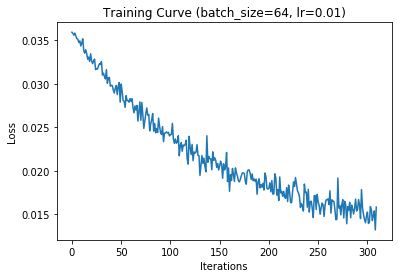

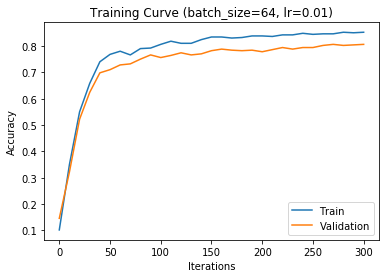

Linear(in_features=784, out_features=10, bias=True)

In [28]:
model = nn.Linear(784, 10)
run_gradient_descent(model, batch_size=64, learning_rate=0.01, num_epochs=10)

## Things to try:

- Changing the batch size
- Changing the weight decay parameter
- Reduce the size of the training set (+ weight decay)
- Changing the learning rate (for your project)